---
<div align="center">
    <h1>🧠💡 <strong>SISTEMA DE RECOMENDAÇÃO PARA E-COMMERCE UTILIZANDO SVD E TF-IDF</strong></h1>
</div>

---

✅ **Filtragem Colaborativa**, utilizando decomposição **SVD** (_Singular Value Decomposition_), que aprende padrões de comportamento com base nas avaliações dos usuários.

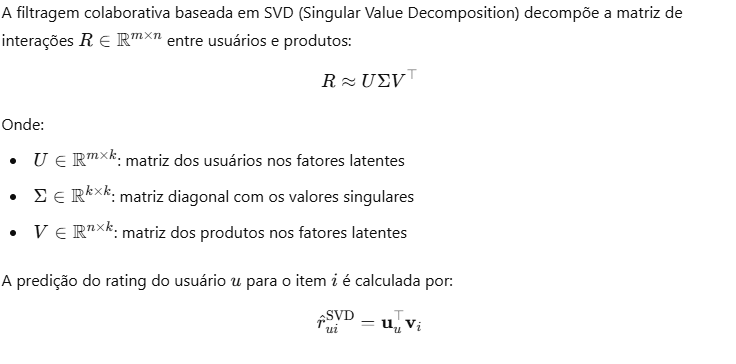

✅ **Filtragem Baseada em Conteúdo**, utilizando vetorização **TF-IDF** aplicada às descrições dos produtos para identificar similaridades semânticas entre os itens.

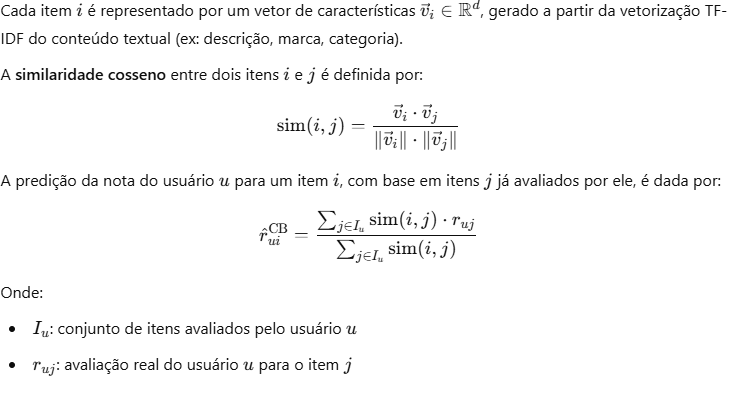

✅ **Modelo Híbrido**, que combina os resultados das abordagens colaborativa e baseada em conteúdo, aumentando a robustez das recomendações, especialmente em cenários com dados escassos (_cold start_).

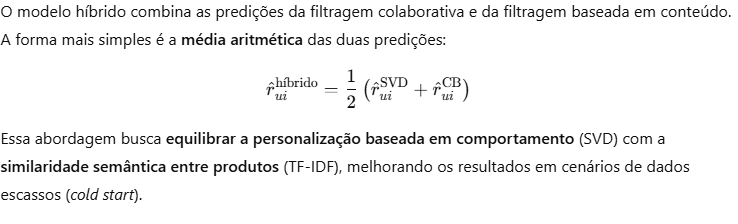

---

## 📦 Bibliotecas Utilizadas

Este bloco realiza a importação de bibliotecas essenciais para a construção e avaliação do sistema de recomendação:

- `pandas` e `numpy`: Manipulação e análise de dados tabulares e numéricos.
- `json`: Leitura de arquivos JSON contendo os dados de entrada (usuários, produtos e interações).
- `train_test_split` (do `sklearn.model_selection`): Divide os dados de interação em conjuntos de treino e teste.
- `mean_squared_error` (do `sklearn.metrics`): Calcula o erro quadrático médio (RMSE) das predições realizadas pelo sistema.
- `TruncatedSVD` (do `sklearn.decomposition`): Aplica decomposição SVD para reduzir a dimensionalidade da matriz de interações — base da filtragem colaborativa.
- `TfidfVectorizer` (do `sklearn.feature_extraction.text`): Transforma os textos das descrições dos produtos em vetores numéricos com base na frequência e importância das palavras — base da filtragem baseada em conteúdo.
- `cosine_similarity` (do `sklearn.metrics.pairwise`): Calcula a similaridade cosseno entre vetores TF-IDF, permitindo encontrar produtos semanticamente semelhantes.


In [44]:
!pip install pandas numpy scikit-learn

In [45]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

---
## 📂 Funções de Preparação de Dados

### 🔹 `carregar_dataset(caminho_json)`

Essa função é responsável por **carregar os dados do sistema de recomendação a partir de um arquivo `.json`** contendo três estruturas principais:

- `usuários`: informações sobre os usuários;
- `produtos`: dados dos produtos (nome, categoria, descrição, etc.);
- `interações`: avaliações feitas por usuários para produtos específicos.

A função abre o arquivo JSON com codificação UTF-8, carrega seu conteúdo em memória e converte os dados em três `DataFrames` do Pandas. Ela retorna as três tabelas para uso posterior no pipeline de recomendação.


### 🔹 `preparar_dados(interacoes)`

Esta função **divide os dados de interações em dois conjuntos**:

- **Treinamento (`train`)**: 80% das interações, usadas para treinar os modelos;
- **Teste (`test`)**: 20% das interações, usadas para avaliar a performance do sistema.

A divisão é feita com `train_test_split`, usando `random_state=42` para garantir reprodutibilidade.



In [46]:
# ------------------------
# Função: carregar dataset
# ------------------------
def carregar_dataset(caminho_json):
    with open(caminho_json, encoding="utf-8") as f:
        data = json.load(f)
    usuarios = pd.DataFrame(data["usuarios"])
    produtos = pd.DataFrame(data["produtos"])
    interacoes = pd.DataFrame(data["interacoes"])
    return usuarios, produtos, interacoes

# -----------------------
# Função: preparar dados
# -----------------------
def preparar_dados(interacoes):
    return train_test_split(interacoes, test_size=0.2, random_state=42)

---
## 🧩 Função: `filtragem_colaborativa(train)`

Esta função implementa a **Filtragem Colaborativa baseada em SVD (Singular Value Decomposition)** para prever avaliações que os usuários dariam a produtos que ainda não interagiram.

### 🔧 Etapas executadas:

1. **Criação da matriz de interações**:
   - Constrói uma matriz `ratings_matrix` com `user_id` nas linhas, `product_id` nas colunas e os valores de avaliação (`rating`) como entradas.
   - Substitui valores ausentes com zero (`fillna(0)`), o que é comum antes da aplicação de SVD.

2. **Configuração do SVD**:
   - Define o número de componentes \( k \) como o mínimo entre 8 e o número de linhas/colunas menos 1, para evitar overfitting ou erro de dimensão.
   - Utiliza `TruncatedSVD` do `sklearn` para reduzir a dimensionalidade da matriz.

3. **Geração dos fatores latentes**:
   - `user_factors`: representa os usuários nos componentes latentes.
   - `product_factors`: representa os produtos nos componentes latentes.

4. **Predição de avaliações**:
   - Calcula a matriz de predições aproximadas com o produto escalar entre usuários e produtos:
     \[
     \hat{R} = U \cdot V
     \]
   - Converte a matriz resultante (`pred_matrix`) em um `DataFrame` com os mesmos índices e colunas da matriz original.

### 📤 Retorno:
- `pred_df`: DataFrame contendo os valores de predição de avaliação para cada par usuário-produto.

In [47]:
# ------------------------------------
# Função: filtragem colaborativa (SVD)
# ------------------------------------
def filtragem_colaborativa(train):
    ratings_matrix = train.pivot_table(index="user_id", columns="product_id", values="rating").fillna(0)
    n_components = min(8, min(ratings_matrix.shape)-1)
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    user_factors = svd.fit_transform(ratings_matrix)
    product_factors = svd.components_
    pred_matrix = np.dot(user_factors, product_factors)
    pred_df = pd.DataFrame(pred_matrix, index=ratings_matrix.index, columns=ratings_matrix.columns)
    return pred_df

---
## 📏 Função: `avaliar_rmse(pred_df, test, train)`

Esta função avalia a qualidade das predições realizadas pelo sistema de recomendação, utilizando a métrica **RMSE** (Root Mean Squared Error), que mede o desvio médio quadrático entre os valores reais e previstos.

### 🔍 Etapas executadas:

1. **Calcula a média de avaliação por produto** (`media_produto`):
   - Usado como fallback (valor padrão) para casos em que o modelo não tenha previsão para um item.

2. **Filtra o conjunto de teste**:
   - Mantém apenas os registros onde o `user_id` e o `product_id` existem nas predições geradas (`pred_df`).

3. **Gera a coluna de predições**:
   - Para cada linha do conjunto de teste:
     - Se houver predição no `pred_df`, ela é usada;
     - Caso contrário, usa-se a média do produto (`media_produto`);
     - Se nem a média existir, utiliza-se um valor neutro padrão `3.0`.

4. **Calcula o RMSE**:
   - Compara os valores reais (`rating`) com os preditos (`predicted`) usando `mean_squared_error` do `sklearn`.

### 📤 Retorno:
- O valor do erro RMSE (quanto menor, melhor o desempenho do modelo).
- O próprio DataFrame de teste com as colunas reais e preditas para análise posterior.

### 📌 Fórmula do RMSE:

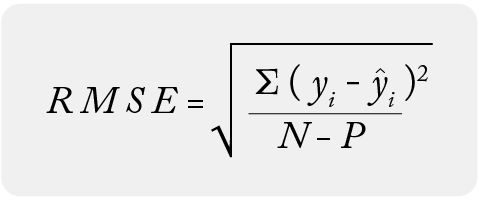


In [48]:
# ---------------------
# Função: avaliar RMSE
# ---------------------
def avaliar_rmse(pred_df, test, train):
    media_produto = train.groupby("product_id")["rating"].mean()
    test_copy = test[test["user_id"].isin(pred_df.index) & test["product_id"].isin(pred_df.columns)].copy()
    test_copy["predicted"] = test_copy.apply(
        lambda row: pred_df.loc[row["user_id"], row["product_id"]]
        if row["user_id"] in pred_df.index and row["product_id"] in pred_df.columns
        else media_produto.get(row["product_id"], 3.0), axis=1
    )
    return mean_squared_error(test_copy["rating"], test_copy["predicted"]), test_copy

---
## 📘 Função: `filtragem_conteudo(produtos, train)`

Esta função implementa a **filtragem baseada em conteúdo**, onde produtos semelhantes são identificados a partir da descrição textual. Para isso, utiliza vetores TF-IDF e a medida de **similaridade cosseno**.

---

### 🧾 Etapas principais:

1. **Criação da descrição completa dos produtos**:
   - Concatena `categoria`, `marca` e `descrição` para formar um texto representativo de cada item.

2. **Vetorização do texto com TF-IDF**:
   - Converte as descrições completas em vetores numéricos esparsos usando `TfidfVectorizer()`.

3. **Cálculo da similaridade entre produtos**:
   - Utiliza `cosine_similarity` para gerar uma matriz onde cada valor representa o quanto dois produtos são semanticamente semelhantes.

4. **Mapeamento entre índices e IDs de produtos**:
   - Cria dois dicionários para converter facilmente entre `product_id` e o índice da matriz TF-IDF.

---

### 🔍 Função interna: `predict(user_id)`

Recebe um `user_id` e retorna um dicionário com as predições de avaliação para todos os produtos com base nas similaridades.

- Se o usuário for novo (sem histórico): atribui nota padrão 3.0 para todos os produtos.
- Caso contrário:
  - Para cada produto avaliado pelo usuário:
    - Recupera a similaridade entre esse produto e todos os outros.
    - Calcula uma média ponderada das avaliações anteriores com base na similaridade.
    - Fórmula usada:

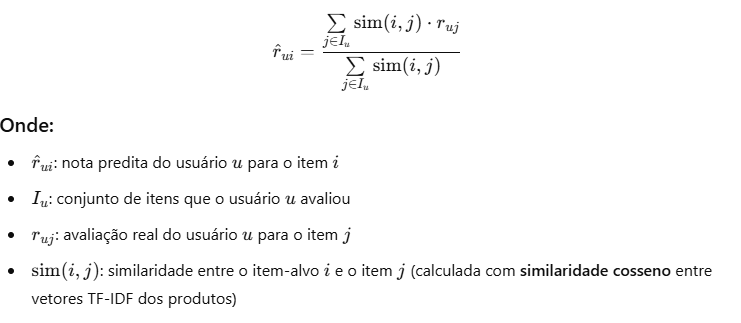

### 📤 Retorno da função principal:

A função `filtragem_conteudo` retorna:
- `predict`: função que realiza as predições personalizadas para qualquer usuário.
- `similaridade`: matriz de similaridade cosseno entre produtos.
- `produto_id_index` e `index_produto_id`: dicionários para mapeamento entre índices e IDs dos produtos.


In [49]:
# ---------------------------------------------------
# Função: filtragem baseada em conteúdo (normalizada)
# ---------------------------------------------------
def filtragem_conteudo(produtos, train):
    produtos["descricao_completa"] = produtos["categoria"] + " " + produtos["marca"] + " " + produtos["descricao"]
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(produtos["descricao_completa"])
    similaridade = cosine_similarity(tfidf_matrix)
    produto_id_index = dict(zip(produtos["product_id"], range(len(produtos))))
    index_produto_id = {v: k for k, v in produto_id_index.items()}

    def predict(user_id):
        user_data = train[train["user_id"] == user_id]
        if user_data.empty:
            return {pid: 3.0 for pid in produtos["product_id"]}

        scores = {}
        sim_sums = {}

        for _, row in user_data.iterrows():
            pid = row["product_id"]
            if pid not in produto_id_index:
                continue
            idx = produto_id_index[pid]
            sim = similaridade[idx]
            for i, s in enumerate(sim):
                target_pid = index_produto_id[i]
                scores[target_pid] = scores.get(target_pid, 0) + s * row["rating"]
                sim_sums[target_pid] = sim_sums.get(target_pid, 0) + s

        return {
            k: (scores[k] / sim_sums[k]) if sim_sums[k] != 0 else 3.0
            for k in scores
        }

    return predict, similaridade, produto_id_index, index_produto_id

---
## ♻️ Função: `sistema_hibrido(pred_cf, pred_cb)`

Essa função implementa um **modelo híbrido de recomendação**, que combina as predições feitas por:

- `pred_cf`: o modelo de **Filtragem Colaborativa** (ex: SVD);
- `pred_cb`: o modelo de **Filtragem Baseada em Conteúdo** (ex: TF-IDF + Similaridade Cosseno).

### 🧠 Como funciona:
- A função realiza uma **média aritmética simples** entre as duas predições:

  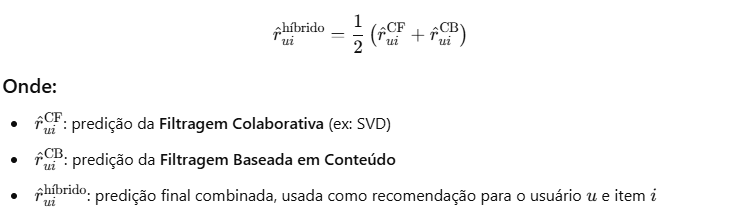


- Isso permite que o sistema aproveite tanto os padrões de comportamento dos usuários quanto as características dos produtos, criando uma recomendação mais robusta e precisa.

### 📤 Retorno:
- Um novo `DataFrame` de predições que equilibra as duas abordagens.

Esse tipo de combinação é especialmente útil para mitigar o problema de **cold start**, aumentando a cobertura e a qualidade das recomendações.


In [50]:
# ------------------------
# Função: sistema híbrido
# ------------------------
def sistema_hibrido(pred_cf, pred_cb):
    return (pred_cf + pred_cb) / 2

---
## 👤 Função: `selecionar_usuario_exemplo(train)`

Esta função seleciona um **usuário representativo** do conjunto de dados de treino, com o objetivo de ser utilizado como exemplo na exibição de recomendações.

### 🔍 O que ela faz:

1. Agrupa o `DataFrame` de treino (`train`) pelo campo `user_id`.
2. Conta o número de interações (linhas) por usuário usando `.size()`.
3. Utiliza `.idxmax()` para retornar o `user_id` que possui o **maior número de interações**.

### 📌 Utilidade:

Esse usuário é útil para:
- Testar a geração de recomendações em exemplos reais;
- Garantir que há dados suficientes para avaliar visualmente a qualidade do sistema.

### 🧠 Exemplo lógico:

```python
# Seleciona o usuário com mais interações:
user_id_exemplo = selecionar_usuario_exemplo(train)


In [51]:
# -----------------------------------
# Função: selecionar usuário exemplo
# -----------------------------------
def selecionar_usuario_exemplo(train):
    historico_usuarios = train.groupby("user_id").size()
    return historico_usuarios.idxmax()

---
## 📌 Função: `mostrar_recomendacoes_para_usuario(user_id, train, produtos, pred_cf, predict_cb)`

Esta função exibe as recomendações de produtos para um usuário específico utilizando três abordagens:

1. **Filtragem Colaborativa**
2. **Filtragem Baseada em Conteúdo**
3. **Modelo Híbrido**


### 👤 Histórico do Usuário

- Primeiro, filtra os dados de treino (`train`) para obter o histórico de interações do `user_id`.
- Caso o usuário tenha histórico, exibe os produtos que ele já avaliou.
- Se não houver histórico (usuário novo), exibe uma mensagem indicativa.


### 🔷 Recomendação Colaborativa (SVD)

- Utiliza a matriz `pred_cf` para ordenar os produtos preditos com maiores notas.
- Remove os produtos que o usuário já avaliou.
- Exibe os **5 melhores produtos recomendados** por essa abordagem.


### 🔶 Recomendação por Conteúdo (TF-IDF)

- Usa a função `predict_cb(user_id)` para obter as predições com base na similaridade entre produtos.
- Ordena os resultados pelo score predito.
- Exibe os **5 melhores produtos**, excluindo os que o usuário já avaliou.


### 🟧 Recomendação Híbrida (CF + Conteúdo)

- Para cada produto, calcula a média entre:
  - A predição colaborativa: `pred_cf[user_id, product_id]`
  - A predição por conteúdo: `scores_cb.get(product_id)`
- Exibe os **5 produtos com maior score híbrido**, também excluindo os produtos já avaliados.


### 💡 Resultado

Ao final, a função mostra três blocos com **listas diferentes de recomendações** baseadas nas três abordagens do sistema.

Essa abordagem comparativa é útil para demonstrar como cada técnica se comporta e ajuda a validar a efetividade da estratégia híbrida.


In [52]:

# -----------------------------
# Função: exibir recomendações
# -----------------------------
def mostrar_recomendacoes_para_usuario(user_id, train, produtos, pred_cf, predict_cb):
    user_data = train[train["user_id"] == user_id]
    historico = user_data if not user_data.empty else pd.DataFrame(columns=["product_id", "rating"])
    print(f"Usuário {user_id} - Histórico:")
    if not historico.empty:
        display(produtos[produtos["product_id"].isin(historico["product_id"])]
                .merge(historico, on="product_id")[["product_id", "nome", "descricao", "rating"]])
    else:
        print("(usuário novo - sem histórico de interações)")

    print("🔷 Recomendação Colaborativa:")
    recomendacoes_cf = pred_cf.loc[user_id].sort_values(ascending=False) if user_id in pred_cf.index else pd.Series({pid: 3.0 for pid in produtos["product_id"]})
    recomendacoes_cf = recomendacoes_cf[~recomendacoes_cf.index.isin(historico["product_id"])]
    display(produtos[produtos["product_id"].isin(recomendacoes_cf.head(5).index)][["product_id", "nome", "descricao"]])

    print("🔶 Recomendação por Conteúdo:")
    scores_cb = predict_cb(user_id)
    recomendacoes_cb = sorted(scores_cb.items(), key=lambda x: x[1], reverse=True)
    ids_cb = [pid for pid, _ in recomendacoes_cb if pid not in historico["product_id"]][:5]
    display(produtos[produtos["product_id"].isin(ids_cb)][["product_id", "nome", "descricao"]])

    print("🟧 Recomendação Híbrida:")
    h_scores = {}
    for pid in produtos["product_id"]:
        if pid in historico["product_id"]:
            continue
        score_cf = pred_cf.loc[user_id, pid] if user_id in pred_cf.index and pid in pred_cf.columns else 3.0
        score_cb = scores_cb.get(pid, 3.0)
        h_scores[pid] = (score_cf + score_cb) / 2
    ids_hybrid = sorted(h_scores.items(), key=lambda x: x[1], reverse=True)[:5]
    display(produtos[produtos["product_id"].isin([pid for pid, _ in ids_hybrid])][["product_id", "nome", "descricao"]])


---
## 🚀 Função: `pipeline_recomendacao(caminho_dataset, user_id_escolhido=None)`

Essa função executa todo o **pipeline do sistema de recomendação híbrido**, incluindo pré-processamento, geração de predições, avaliação por RMSE e exibição de recomendações para um usuário.

### 📂 Etapas do pipeline:

1. **Carregamento e divisão do dataset**:
   - Lê o JSON com usuários, produtos e interações.
   - Divide os dados de interações em treino e teste usando `train_test_split`.

2. **Filtragem Colaborativa (SVD)**:
   - Gera a matriz de predições `pred_cf` com base nas avaliações do usuário.
   - Calcula o RMSE comparando as predições com os dados reais do conjunto de teste.

3. **Filtragem por Conteúdo (TF-IDF)**:
   - Executa a função `filtragem_conteudo` para obter o preditor baseado nas descrições dos produtos.
   - Aplica o preditor no conjunto de teste e calcula o RMSE correspondente.
   - Agrupa os resultados por usuário-produto e forma um `DataFrame` no mesmo formato da predição colaborativa.

4. **Modelo Híbrido**:
   - Combina as predições colaborativas e por conteúdo por média simples.
   - Aplica as predições híbridas ao conjunto de teste e calcula o RMSE resultante.


### 📊 Resultados Impressos:

Ao final da função, são exibidos:

- ✅ O RMSE (erro quadrático médio) das três abordagens:
  - Filtragem Colaborativa
  - Filtragem por Conteúdo
  - Sistema Híbrido

- 📌 Amostra de Recomendação personalizada:
  - Seleciona um `user_id` (se não for passado como argumento, escolhe automaticamente o usuário com mais histórico).
  - Exibe as recomendações geradas pelas três abordagens (via função `mostrar_recomendacoes_para_usuario`).

In [53]:
def pipeline_recomendacao(caminho_dataset, user_id_escolhido=None):
    _, produtos, interacoes = carregar_dataset(caminho_dataset)
    train, test = preparar_dados(interacoes)

    pred_cf = filtragem_colaborativa(train)
    rmse_cf, _ = avaliar_rmse(pred_cf, test, train)

    predict_cb, _, _, _ = filtragem_conteudo(produtos, train)
    test_cb = test.copy()
    test_cb["predicted"] = test_cb.apply(
        lambda row: predict_cb(row["user_id"]).get(row["product_id"], 3.0), axis=1
    )
    rmse_cb = mean_squared_error(test_cb["rating"], test_cb["predicted"])

    test_cb_grouped = test_cb.groupby(["user_id", "product_id"])["predicted"].mean().reset_index()
    pred_cb_df = test_cb_grouped.pivot(index="user_id", columns="product_id", values="predicted").fillna(3.0)
    
    test_hybrid = test.copy()
    test_hybrid = test_hybrid[test_hybrid["user_id"].isin(pred_cf.index) & test_hybrid["product_id"].isin(pred_cf.columns)]
    test_hybrid["predicted"] = test_hybrid.apply(
        lambda row: (pred_cf.loc[row["user_id"], row["product_id"]] + 
                     pred_cb_df.loc[row["user_id"], row["product_id"]]) / 2
        if row["user_id"] in pred_cb_df.index and row["product_id"] in pred_cb_df.columns else 3.0,
        axis=1
    )
    rmse_hybrid = mean_squared_error(test_hybrid["rating"], test_hybrid["predicted"])

    print("\n🎯 Resultados RMSE:")
    print(f"    - Filtragem Colaborativa: {rmse_cf:.4f}")
    print(f"    - Filtragem Conteúdo:     {rmse_cb:.4f}")
    print(f"    - Sistema Híbrido:        {rmse_hybrid:.4f}")

    print("\n📌 Amostra de Recomendações (Top 5 por método):")
    user_exemplo = user_id_escolhido if user_id_escolhido in train["user_id"].unique() else selecionar_usuario_exemplo(train)
    mostrar_recomendacoes_para_usuario(user_exemplo, train, produtos, pred_cf, predict_cb)

In [54]:
pipeline_recomendacao("dataset.json", 81)


🎯 Resultados RMSE:
    - Filtragem Colaborativa: 9.7452
    - Filtragem Conteúdo:     0.4755
    - Sistema Híbrido:        2.7524

📌 Amostra de Recomendações (Top 5 por método):
Usuário 81 - Histórico:


,product_id,nome,descricao,rating
0,13,Fone JBL Tune 510BT,"Fone JBL Tune 510BT, ideal para quem busca qua...",5
1,19,Cabo USB-C Baseus,"Cabo USB-C Baseus, ideal para quem busca quali...",5
2,20,Suporte Veicular Magnético,"Suporte Veicular Magnético, ideal para quem bu...",5


🔷 Recomendação Colaborativa:


,product_id,nome,descricao
3,4,Xiaomi Redmi Note 12,"Xiaomi Redmi Note 12, ideal para quem busca qu..."
7,8,Samsung Book Go,"Samsung Book Go, ideal para quem busca qualida..."
10,11,Smart TV TCL 32,"Smart TV TCL 32, ideal para quem busca qualida..."
11,12,Soundbar Samsung,"Soundbar Samsung, ideal para quem busca qualid..."
14,15,Samsung Galaxy Buds2,"Samsung Galaxy Buds2, ideal para quem busca qu..."


🔶 Recomendação por Conteúdo:


,product_id,nome,descricao
2,3,Motorola Edge 40,"Motorola Edge 40, ideal para quem busca qualid..."
3,4,Xiaomi Redmi Note 12,"Xiaomi Redmi Note 12, ideal para quem busca qu..."
8,9,Smart TV LG 55,"Smart TV LG 55, ideal para quem busca qualidad..."
10,11,Smart TV TCL 32,"Smart TV TCL 32, ideal para quem busca qualida..."
12,13,Fone JBL Tune 510BT,"Fone JBL Tune 510BT, ideal para quem busca qua..."


🟧 Recomendação Híbrida:


,product_id,nome,descricao
7,8,Samsung Book Go,"Samsung Book Go, ideal para quem busca qualida..."
11,12,Soundbar Samsung,"Soundbar Samsung, ideal para quem busca qualid..."
12,13,Fone JBL Tune 510BT,"Fone JBL Tune 510BT, ideal para quem busca qua..."
18,19,Cabo USB-C Baseus,"Cabo USB-C Baseus, ideal para quem busca quali..."
19,20,Suporte Veicular Magnético,"Suporte Veicular Magnético, ideal para quem bu..."
